# Build Gibbs and Metropolis-Hastings algorithms in Python from scratch


### William Suzuki (8012391) and Pedro Lima () - FEARP USP 

In [1]:
#load packages #################################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.stats import gamma
from scipy.stats import norm
from random import choices

In [2]:
#matplotlib
%matplotlib inline

*Este trabalho foi apresentado na disciplina de Introdução à Métodos Bayesianos ministrada pelo Prof. Dr. Jorge Achcar, no segundo semestre de 2019.*

*Faculdade de Medicina departamento de Medicina Social.*

### A Problem:

Univariate Gaussian distribution
$$ f(x) = \dfrac{1}{\sqrt{2 \pi \sigma^2}}  \exp\left(  - \dfrac{(x-\mu)^2}{2 \sigma^2}   \right)     $$
we assume the value of $\sigma^2=1$ then
$$ f(x) = \dfrac{1}{\sqrt{2 \pi }}  \exp\left(  - \dfrac{(x-\mu)^2}{2 }   \right)     $$
Jeffrey's prior for the mean is
$$ \pi(\mu ) \propto \dfrac{1}{\sigma}$$


the posterior is 
$$ \pi(\mu|\sigma^2, Y) \propto \exp\left(   \dfrac{1}{2}  \dfrac{( \mu - \bar{x}  )^2}{1/n}  \right) $$
hence the posterior is a Gaussian$\left( \bar{x},\frac{1}{n} \right)$ distribution.

Calculations for the above statement:
$$ \pi(\mu|\sigma^2, Y) \propto \dfrac{1}{ (2 \pi )^{n/2} }  \exp\left( -\dfrac{1}{2}  \sum_{i=1}^{n} (x_i-\mu)^2 \right) \dfrac{1}{\sigma}  \propto  
\exp\left( -\dfrac{1}{2}  \sum_{i=1}^{n} (x_i^2- 2 \mu x_i + \mu^2 ) \right) = $$
$$  \exp\left( -\dfrac{1}{2} ( \sum_{i=1}^{n} x_i^2- 2 \mu \sum_{i=1}^{n} x_i + n \mu^2 ) \right) =  
 \exp\left( -\dfrac{1}{2}  \sum_{i=1}^{n} x_i^2 +  \dfrac{1}{2} 2 \mu  n \bar{x} -\dfrac{1}{2} n \mu^2  \right) =  $$
$$  \exp\left( -\dfrac{1}{2}  \sum_{i=1}^{n} x_i^2 +  \mu  n \bar{x} -\dfrac{1}{2} n \mu^2  \right) \propto 
 \exp\left(   \mu  n \bar{x} -\dfrac{1}{2} n \mu^2  \right) \propto $$
let us complete the square inside the exponential
$$ \propto  \exp\left( -\dfrac{1}{2} n \bar{x}^2  + \dfrac{1}{2} n 2 \mu \bar{x} -\dfrac{1}{2} n \mu^2  \right) =
\exp\left(  -n\dfrac{1}{2} (  \bar{x}^2  - 2 \mu \bar{x} + \mu^2 ) \right) =
\exp\left(   \dfrac{1}{2}  \dfrac{( \mu - \bar{x}  )^2}{1/n}  \right) $$

In [3]:
## generate data ###############################################
"""
consider a problem where we want to estimate the mean of a Gaussian 
distribution
DGP: mean=2; variance=1; n=10 number of observations
"""
np.random.seed(seed=123)
rv1 = np.random.normal(loc=2, scale=1, size=10)#rv1 is our random sample.

rv3 = pd.DataFrame(rv1) #change format to a data frame
rv3.shape
rv3.head()
"""
for this problem we assume that we know the variance, variance =1
the objective is to estimate the mean, for this we'll use 
the Ordinary Monte Carlo method
"""

m1 = np.mean(rv1)
m1

1.7304838896736723

Note that the mean of the real distribution is $\mu=2$

## Ordinary Monte Carlo

array([0.14463819, 3.3516178 ])

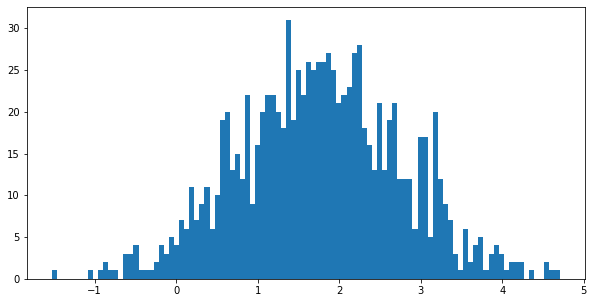

In [4]:
## Ordinary Monte Carlo #######################################
#create a simulation of size 1000
np.random.seed(seed=321)
rv2 = np.random.normal(loc=m1, scale=1, size=1000) #mean=m1

plt.figure(figsize=(10,5)) #plot histogrm
plt.hist(rv2, bins=100)

#estimation for the mean
np.mean(rv2)

#estimation for credible interval
np.quantile(rv2,[.05,.95])

The graph above is the histogram of simulation from the conditional posterior distribution of $\mu$.

## Sampling Importance Resampling (SIR)

Suppose that the true distribution is a Gamma$(3,3)$ but we don't know that and we don't know how to find this density. 

We'll use a Gaussian distribution to find the posterior.

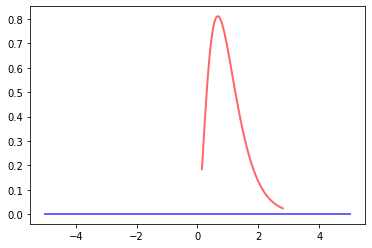

In [5]:
##Sampling Importance Resampling (SIR) #####################################
#suppose that we have a posterior with a Gamma(3,3) format, but we dont know.
#use gaussian in the sampling step
#loc1, scale1 are from the Gaussian
loc1=0
scale1=500 #scale is standard deviation
norm.mean(loc=loc1, scale=scale1)
norm.var(loc=loc1, scale=scale1)
norm.std(loc=loc1, scale=scale1)

np.random.seed(seed=123)
rv1 = np.random.normal(loc=loc1, scale=scale1, size=10000)
rv1[0:10]
np.mean(rv1)
np.std(rv1)
np.var(rv1)
np.max(rv1)
np.min(rv1)


b1, b2 = -5,5
x = np.linspace(b1,b2,100)
y = norm.pdf(x=x, loc=loc1, scale=scale1)
fig, ax = plt.subplots(1, 1) #it creates another plot
ax.plot(x, y,'b-', lw=2, alpha=0.6, label='Gaussian pdf')

#Gamma(3,3)
a = 3
b = 3
scale2=1/b
b1, b2 = gamma.ppf(q=[0.01,0.99], a=a, scale=scale2)
x = np.linspace(b1,b2, 100)
y = gamma.pdf(x=x, a=a, scale=scale2)
#fig, ax = plt.subplots(1, 1) #it creates another plot
ax.plot(x, y,'r-', lw=2, alpha=0.6, label='gamma pdf')


We can see from the figure that the Gaussian distribution is very flat
due to the Gaussian be spread in a large area.
The ideal situation is that on the step of first sampling the support
of sampling is close to the posterior's majority support (places inside 1% and 99%). 
But we don't know the posterior format nor majority support.
Idea: We could make in this an iterative process where we try to find
a close enough area where is the majority support.

In [6]:
#Normal(0,100), what are the .01 and .99 percentiles?
norm.ppf(q=[.01,.99],loc=loc1, scale=scale1)

array([-1163.17393702,  1163.17393702])

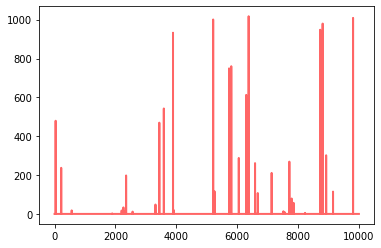

In [7]:
#p1 probabilities of Gaussian random sample
p1 = norm.pdf(x=rv1,loc=loc1, scale=scale1)
#g1 probabilities of random sample from true distribution Gamma(3,3)
g1 = gamma.pdf(x=rv1, a=a, scale=scale2)
#"w" weights for the resampling step
w=g1/p1
len1 = len(w)
fig, ax = plt.subplots(1, 1) 
ax.plot( w,'r-', lw=2, alpha=0.6, label='graph of weights "w"')
#peaks show where the weights were high

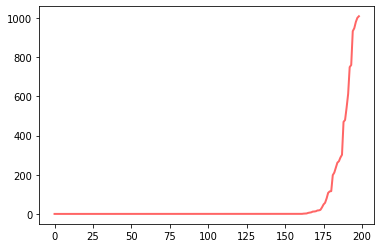

In [8]:
#show proportion of samples that got high weight
y1=np.sort(w)
y2 = y1[-200:-1]
fig, ax = plt.subplots(1, 1) 
ax.plot(y2,'r-', lw=2, alpha=0.6, label='')

In [9]:
#number of points that have more than 0.0001 probability of being drawn
#from a total of 10000 
np.sum(w>0.0001)

60

In [10]:
#make data frame with weights and value from first draw rv1
df1 = pd.DataFrame({"sample":rv1,
					"weights":w})
df1.head()
#keep only lines that have weights higher than 0.0001

,sample,weights
0,-542.815302,0.000000e+00
1,498.672723,0.000000e+00
2,141.489249,1.596720e-176
3,-753.147357,0.000000e+00
4,-289.300126,0.000000e+00


In [11]:
#rvc1 random vector clean 1
rvc1=rv1[w>0.0001]
len(rvc1)
#wc1 weights clean 1
wc1 = w[w>0.0001]

In [12]:
#sampling with reposition and with weights
dd1 = choices(population=rvc1, #values to be drawn
	weights=wc1, #weights of drawn
	k=1000) #number of draws
dd1

[0.7304121717647845,
 1.4229579484055097,
 1.4229579484055097,
 0.4886946199339496,
 0.4886946199339496,
 1.7709955035428764,
 0.4886946199339496,
 0.5841226961623911,
 0.657563401875239,
 0.4886946199339496,
 0.5841226961623911,
 1.8835585073837462,
 1.755682502986249,
 0.36829333123183144,
 1.7709955035428764,
 1.7709955035428764,
 0.657563401875239,
 0.36829333123183144,
 0.7304121717647845,
 1.3432649198051743,
 0.36829333123183144,
 1.3432649198051743,
 1.755682502986249,
 0.362375422903895,
 0.4886946199339496,
 2.1792583769184635,
 1.2605258928561127,
 0.8052437602294719,
 1.4229579484055097,
 3.030356990831167,
 1.8225774868889855,
 1.4229579484055097,
 0.657563401875239,
 0.362375422903895,
 0.4886946199339496,
 1.4359586369122779,
 1.3432649198051743,
 0.5841226961623911,
 1.3432649198051743,
 0.7304121717647845,
 1.3432649198051743,
 0.7304121717647845,
 0.4886946199339496,
 0.8052437602294719,
 0.5045625661728474,
 0.8052437602294719,
 0.362375422903895,
 1.8835585073837462

(array([0.0996005 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 2.81371424, 0.        , 0.        ,
        2.01691021, 2.36551197, 0.        , 1.9173097 , 2.76391399,
        0.        , 1.84260932, 0.        , 1.8177092 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.19520605,
        0.        , 1.17030592, 0.        , 0.87150441, 0.87150441,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.54780277, 0.6723034 , 1.17030592, 0.34860176, 0.        ,
        0.44820227, 0.42330214, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.6723034 , 0.27390139, 0.        ,
        0.        , 0.        , 0.14940076, 0.        , 0.        ,
        0.        , 0.0996005 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.12450063, 0.        , 0.        ,
        0.        , 0.        , 0.02490013, 0.02

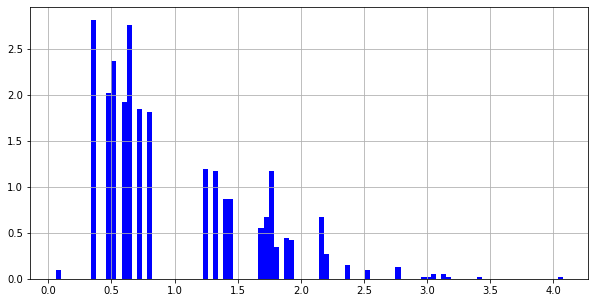

In [13]:
#plot histogram of estimated posterior
plt.figure(figsize=(10,5)) 
plt.grid(True)
plt.hist(dd1, bins=100,color='b',density=True)

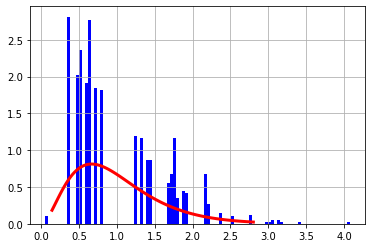

In [14]:
#plot histogram of estimated posterior (SIR)
#and true posterior
fig, ax = plt.subplots(1, 1) #it creates another plot
plt.grid(True)
ax.hist(dd1, bins=100,color='b',density=True)
ax.plot(x, y,'r-', lw=3, alpha=1, label='Gaussian pdf')

Compare the moments generated from the SIR method and the true moments.

True mean is 1.

True variance is 0.33

In [15]:
#SIR posterior mean, it should be close to 1
np.mean(dd1)

0.9922706034936355

In [16]:
#SIR posterior variance, it should be close to .33
np.var(dd1)

0.3744115350675435

# Markov Chain Monte Carlo

## Gibbs Sampling